In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import biomassml
from biomassml.build_model import *
from biomassml.coregionalized_regressor import *
from biomassml.io import *
from biomassml.metrics import *
from biomassml.predict_outputs import *
from biomassml.plotting import *

DATA_DIR = '.../data/'
MODEL_DIR = '.../models/'

output_names = ['CO (vol%)', r'H$_2$ (vol%)', 'COMBgas (vol%)', r'GAS (m$^3$/kg biom)', r'CH$_4$ (vol%)']

### multioutput GPR model - LOOCV
### 12 features -  4 outputs (volCO, volH2, volCOMB, GAS)

In [3]:
dfGASIF_dataset = pd.read_csv(os.path.join(DATA_DIR, 'data_GASIF_biomass.csv'))

In [4]:
dfGASIF_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BIOMASS           30 non-null     object 
 1   SA                30 non-null     float64
 2   SBR               30 non-null     float64
 3   HHVbiom (MJ/kg)   30 non-null     float64
 4   T (K)             30 non-null     int64  
 5   SR                30 non-null     float64
 6   C (%)             30 non-null     float64
 7   N (%)             30 non-null     float64
 8   H (%)             30 non-null     float64
 9   S (%)             30 non-null     float64
 10  O (%)             30 non-null     float64
 11  ash (%)           30 non-null     float64
 12  VM (%)            30 non-null     float64
 13  FC (%)            30 non-null     float64
 14  MC (%)            30 non-null     float64
 15  volCO2 (%)        30 non-null     float64
 16  volCO (%)         30 non-null     float64
 17 

In [5]:
FEATURES_GASIF = pd.concat([dfGASIF_dataset.iloc[:,1:7], dfGASIF_dataset.iloc[:,[8,10,11,12,13,14]]], axis=1)
FEATURES_GASIF.head(1)

,SA,SBR,HHVbiom (MJ/kg),T (K),SR,C (%),H (%),O (%),ash (%),VM (%),FC (%),MC (%)
0,2.33,1.1,19.5649,1173,0.13,49.44,5.85,42.9,1.45,78.93,19.62,6.52


In [6]:
TARGETS_GASIF = dfGASIF_dataset.iloc[:,[16,18,19,20]]
TARGETS_GASIF.head(1)

,volCO (%),volH2 (%),volCOMB (%),GAS (m3/kg biom)
0,23.6541,36.4296,67.4756,0.7975


In [7]:
features = list(FEATURES_GASIF.columns)
X = FEATURES_GASIF
y = TARGETS_GASIF

In [8]:
kernel_rbf_lin = get_rbf_kernel(len(features), ARD=True) + get_linear_kernel(len(features), ARD=True)

### train model

In [9]:
model_GPR_loocv = build_coregionalized_model(X.values, y.values, kernel=kernel_rbf_lin)

test_metrics, prediction_collection_train, prediction_collection_test = loocv_train_test(
    model_GPR_loocv, X.values, y.values, coregionalized=True, n_restarts=20)

dump_joblib(model_GPR_loocv, os.path.join(MODEL_DIR, 'model_GPR_loocv'))

### load model

In [11]:
model = load_joblib(os.path.join(MODEL_DIR, 'model_GPR_loocv'))

#### get scalers from dfGASIF_dataset including CH4

In [13]:
TARGETS_GASIF_wCH4 = dfGASIF_dataset.iloc[:,[16,18,19,20,17]]
TARGETS_GASIF_wCH4.head(1)

,volCO (%),volH2 (%),volCOMB (%),GAS (m3/kg biom),volCH4 (%)
0,23.6541,36.4296,67.4756,0.7975,7.3919


In [14]:
x_scaler, y_scaler_wCH4 = get_scalers(FEATURES_GASIF, TARGETS_GASIF_wCH4)
joblib.dump(x_scaler, 'x_scaler')
joblib.dump(y_scaler_wCH4, 'y_scaler_wCH4')

['y_scaler_wCH4']

#### predict CH4

In [15]:
y_pred_mu_CH4 = predict_CH4_covar(X, y, model, x_scaler, y_scaler_wCH4)[0]
y_pred_std_CH4_covar = predict_CH4_covar(X, y, model, x_scaler, y_scaler_wCH4)[1]

y_pred_mu_CH4_scaled = ((y_pred_mu_CH4 - y_scaler_wCH4.mean_[4])/sqrt(y_scaler_wCH4.var_[4])).flatten() 
y_pred_std_CH4_covar_scaled = (y_pred_std_CH4_covar/sqrt(y_scaler_wCH4.var_[4])).flatten()

In [20]:
def individual_plot(n_output, ax):
    y_true = np.concatenate([pred[n_output]["true"] for pred in prediction_collection_test])
    y_pred_mu = np.concatenate([pred[n_output]["mu"] for pred in prediction_collection_test])
    y_pred_std = np.concatenate([pred[n_output]["std"] for pred in prediction_collection_test])
    make_parity_plot(y_true, y_pred_mu.flatten(), ax, y_pred_std.flatten(), ls='none', linewidth=1, color='#337eb8')
    ax.set_title(output_names[n_output], fontsize=19)
    ax.set_xlabel('true', fontsize=18)
    ax.set_ylabel('predicted', fontsize=18)
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

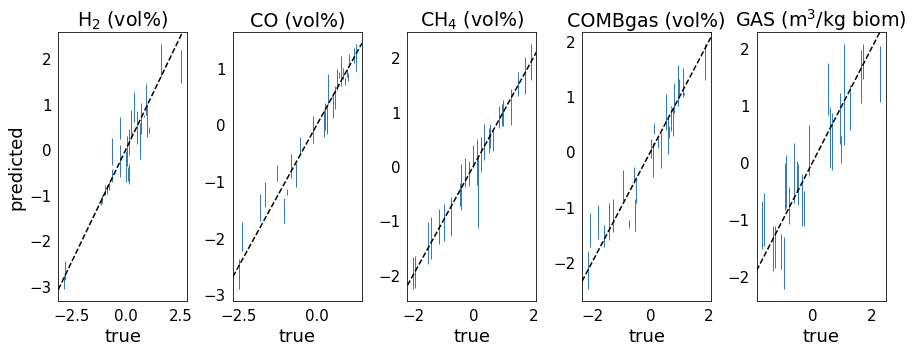

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(12.5, 5))
individual_plot(1, ax[0])
individual_plot(0, ax[1])
ax[1].set_ylabel(None)

y_true = pd.DataFrame(y_scaler_wCH4.transform(TARGETS_GASIF_wCH4)).iloc[:,4]
make_parity_plot(y_true, y_pred_mu_CH4_scaled.flatten(), ax[2], y_pred_std_CH4_covar_scaled.flatten(),
                 ls='none', linewidth=1, color='#337eb8')
ax[2].set_title(output_names[4], fontsize=19)
ax[2].set_xlabel('true', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(axis='both', bottom=False, left=False)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)

individual_plot(2, ax[3])
ax[3].set_ylabel(None)
individual_plot(3, ax[4])
ax[4].set_ylabel(None)

fig.tight_layout()

In [26]:
def individual_plot_unscaled(n_output, ax):
    y_true = np.concatenate([pred[n_output]["true"] for pred in prediction_collection_test])
    y_pred_mu = np.concatenate([pred[n_output]["mu"] for pred in prediction_collection_test])
    y_pred_std = np.concatenate([pred[n_output]["std"] for pred in prediction_collection_test])
    y_true = y_true*sqrt(y_scaler_wCH4.var_[n_output]) + y_scaler_wCH4.mean_[n_output]
    y_pred_mu = y_pred_mu*sqrt(y_scaler_wCH4.var_[n_output]) + y_scaler_wCH4.mean_[n_output]
    y_pred_std = y_pred_std*sqrt(y_scaler_wCH4.var_[n_output])

    make_parity_plot(y_true, y_pred_mu.flatten(), ax, y_pred_std.flatten(), ls='none', linewidth=1, color='#337eb8')
    ax.set_title(output_names[n_output], fontsize=19)
    ax.set_xlabel('true', fontsize=18)
    ax.set_ylabel('predicted', fontsize=18)
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

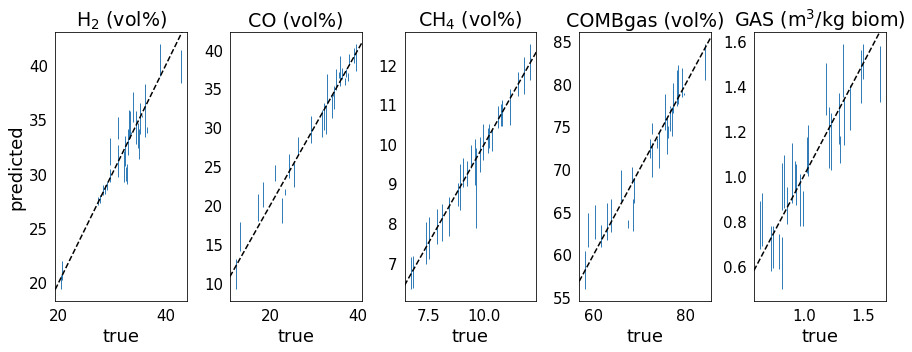

In [27]:
fig, ax = plt.subplots(1, 5, figsize=(12.5, 5))
individual_plot_unscaled(1, ax[0])
individual_plot_unscaled(0, ax[1])
ax[1].set_ylabel(None)

y_true = TARGETS_GASIF_wCH4.iloc[:,4]
make_parity_plot(y_true, y_pred_mu_CH4.flatten(), ax[2], y_pred_std_CH4_covar.flatten(),
                 ls='none', linewidth=1, color='#337eb8')
ax[2].set_title(output_names[4], fontsize=19)
ax[2].set_xlabel('true', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(axis='both', bottom=False, left=False)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)

individual_plot_unscaled(2, ax[3])
ax[3].set_ylabel(None)
individual_plot_unscaled(3, ax[4])
ax[4].set_ylabel(None)

fig.tight_layout()